# Projet 6: Classifiez automatiquement des biens de consommation

Etudier la faisabilité d'un moteur de **classification des articles en différentes catégories** basé sur une **image** et une **description** pour l'automatisation de l'attribution de la catégorie de l'article.

Les **descriptions des produits et des images** doivent êtres **prétraitées**, une **réduction de dimension** effectuée puis un **clustering**.

Les résultats de la réduction de dimension et du clustering doivent être présentés sous forme de **graphiques en 2 dimensions** et confirmés par un **calcul de similarité entre les catégories réelles et les clusters**. Les résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

Pour les **features texte**:
- 2 approches de type "bag_of-word": comptage simple de mots et Tf_idf
- 1 approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText)
- 1 approche de type word/sentence embedding avec BERT
- 1 approche de type word/sentence embedding avec USE (Universal Sentence Encoder)

Pour les **features image**:
- un algorithme de type SIFT / ORB / SURF
- un algorithme de type CNN Transfer Learning

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et connaissance des données](#load)
3. [Nettoyage des données textuelles](#txt)
4. [Extraction de l'information du texte](#extract)
    1. [Approches de type bag of word](#bag)
        1. [Comptage simple de mots (Countvectorizer)](#cpte)
        2. [Tf_idf](#Tf_idf)

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
# Pour vérifier si la convention PEP8 est respectée
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [2]:
# builtin
import os
import sys
import time
import random

In [3]:
# data
import numpy as np
import pandas as pd
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True, nb_workers=6)

# Configuration Pandas
pd.set_option('display.max_colwidth', None)

In [4]:
# viz
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
import seaborn as sns
from wordcloud import WordCloud

# Configuration générale des graphiques
parameters = {'axes.labelsize': 13,
              'axes.titlesize': 16,
              'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [6]:
# Natural Language Processing
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('words')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer, PorterStemmer
import collections

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Chargement et connaissance des données <a class="anchor" id="load"></a>

#### Import

In [7]:
# Import des données textuelles
data = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv',
                   sep=',',
                   encoding='utf-8')

In [8]:
# Visualisation des 5 premières lignes du dataset
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""key""=>""Type"", ""value""=>""Bath Towel""}, {""key""=>""GSM"", ""value""=>""500""}, {""key""=>""Model Name"", ""value""=>""Sathiyas cotton bath towel""}, {""key""=>""Ideal For"",

#### Dimension du dataset

In [9]:
def shape_total_nan(df):
    '''Fonction qui retourne le nombre de lignes,
    de variables, le nombre total de valeurs manquantes et
    le pourcentage associé'''
    missing = df.isna().sum().sum()
    missing_percent = round(missing
                            / (df.shape[0] * df.shape[1])
                            * 100,
                            2)

    print(f"Nombre de lignes: {df.shape[0]}")
    print(f"Nombre de colonnes: {df.shape[1]}")
    print(f"Nombre total de NaN du dataset: {missing}")
    print(f"% total de NaN du dataset: {missing_percent}%")

In [10]:
# Shape et nombre de données manquantes
shape_total_nan(data)

Nombre de lignes: 1050
Nombre de colonnes: 15
Nombre total de NaN du dataset: 341
% total de NaN du dataset: 2.17%


#### Principales statistiques

In [11]:
def describe_variables(data):
    ''' Fonction qui prend un dataframe en entrée, et retourne un
    récapitulatif qui contient le nom des variables, leur type, un
    exemple de modalité, le nombre total de lignes, le nombre et
    pourcentage de valeurs distinctes, le nombre et pourcentage de
    valeurs non manquantes et de valeurs manquantes (NaN) et les
    principales statistiques pour les variables numériques (moyenne,
    médiane, distribution, variance, écart type, minimum, quartiles et
    maximum)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns=[
        'Variable name', 'Variable type', 'Example', 'Raws', 'Distinct',
        '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean',
        'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min', '25%',
        '75%', 'Max'
    ])

    # Pour chaque colonne du dataframe
    for col in data.columns:

        # Définition des variables
        # type de la variable (object, float, int...)
        var_type = data[col].dtypes
        # premier élément notNA
        example = data[data[col].notna()][col].iloc[0]
        # nombre total de lignes
        nb_raw = len(data[col])
        # nombre de valeurs non manquantes
        count = len(data[col]) - data[col].isna().sum()
        # % de valeurs non manquantes
        percent_count = round(data[col].notnull().mean(), 4)*100
        # nombre de modalités que peut prendre la variable
        distinct = data[col].nunique()
        # % de valeurs distinctes
        percent_distinct = round(data[col].nunique()/len(data[col]), 4)
        percent_distinct = percent_distinct * 100
        # nombre de valeurs manquantes
        missing = data[col].isna().sum()
        # % de valeurs manquantes
        percent_missing = round(data[col].isna().mean(), 4)*100

        # Pour les var de type 'int' ou 'float': on remplit toutes les col
        if var_type == 'int32' or var_type == 'int64' or var_type == 'float':
            df = pd.concat([df, pd.DataFrame([[col, var_type, example, nb_raw,
                                               distinct, percent_distinct,
                                               count,
                                               percent_count,
                                               missing,
                                               percent_missing,
                                               round(data[col].mean(), 2),
                                               round(data[col].median(), 2),
                                               round(data[col].skew(), 2),
                                               round(data[col].kurtosis(), 2),
                                               round(data[col].var(), 2),
                                               round(data[col].std(), 2),
                                               round(data[col].min(), 2),
                                               round(data[col].quantile(0.25),
                                                     2),
                                               round(data[col].quantile(0.75),
                                                     2),
                                               data[col].max()]],
                                             columns=['Variable name',
                                                      'Variable type',
                                                      'Example',
                                                      'Raws',
                                                      'Distinct',
                                                      '% distinct',
                                                      'Not NaN',
                                                      '% Not NaN',
                                                      'NaN',
                                                      '% NaN',
                                                      'Mean',
                                                      'Median',
                                                      'Skew',
                                                      'Kurtosis',
                                                      'Variance',
                                                      'Std',
                                                      'Min',
                                                      '25%',
                                                      '75%',
                                                      'Max'])])

            # Pour les variables d'un autre type: on ne remplit que
            # les variables de compte

        else:
            df = pd.concat([df, pd.DataFrame([[col, var_type, example,
                                               nb_raw, distinct,
                                               percent_distinct,
                                               count,
                                               percent_count, missing,
                                               percent_missing,
                                               '', '', '', '', '', '',
                                               '', '', '', '']],
                                             columns=['Variable name',
                                                      'Variable type',
                                                      'Example',
                                                      'Raws',
                                                      'Distinct',
                                                      '% distinct',
                                                      'Not NaN',
                                                      '% Not NaN',
                                                      'NaN',
                                                      '% NaN',
                                                      'Mean',
                                                      'Median',
                                                      'Skew',
                                                      'Kurtosis',
                                                      'Variance',
                                                      'Std',
                                                      'Min',
                                                      '25%',
                                                      '75%',
                                                      'Max'])])

    return df.reset_index(drop=True)

In [12]:
# Principales statistiques du jeu de données
describe_variables(data)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,uniq_id,object,55b85ea15a1536d46b7190ad6fff8ce7,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
1,crawl_timestamp,object,2016-04-30 03:22:56 +0000,1050,149,14.19,1050,100.00,0,0.00,,,,,,,,,,
2,product_url,object,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
3,product_name,object,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
4,product_category_tree,object,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",1050,642,61.14,1050,100.00,0,0.00,,,,,,,,,,
5,pid,object,CRNEG7BKMFFYHQ8Z,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
6,retail_price,float64,1899.0,1050,354,33.71,1049,99.90,1,0.10,2186.2,999.0,19.78,473.69,58357825.99,7639.23,35.0,555.0,1999.0,201000.0
7,discounted_price,float64,899.0,1050,424,40.38,1049,99.90,1,0.10,1584.53,600.0,21.22,523.39,55877115.23,7475.1,35.0,340.0,1199.0,201000.0
8,image,object,55b85ea15a1536d46b7190ad6fff8ce7.jpg,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
9,is_FK_Advantage_product,bool,False,1050,2,0.19,1050,100.00,0,0.00,,,,,,,,,,


#### Données dupliquées

In [13]:
# Lignes entières et uniq_id dupliqués
print(f"Lignes en doublons: {data.duplicated().sum()}")
print(f"uniq_id en doublons: {data.duplicated(subset='uniq_id').sum()}")

Lignes en doublons: 0
uniq_id en doublons: 0


#### Features

<div class="alert alert-block alert-warning">
    <p>id et nom du produit (uniq_id et product_name) </p>
</div>

In [14]:
data[['uniq_id', 'product_name']].sample(5)

,uniq_id,product_name
940,9c9385abdb73ec1f1f93acaf81c6e1d7,Digilight 200 inch Blue Rice Lights
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double Bedsheet
631,e40e9b4ae48e452dc407d299b467d0c3,"CHOCOBERRY Baby Girl's Printed White, Dark Blue Top, Capri & Shorts Set"
422,0e1e3861d54a8a17b7b91f04071a4ca3,Clear Face Kesar Chandan Multivitamin Nourishing Skin Cream With Almond Honey Skin Cream
312,c20bf28cd809790c04e78fdaf47c038f,Intex W150D


Ces deux variables peuvent être utilisées comme clef unique des produits mais l'on préfèrera l'uniq_id qui est figé, à l'inverse du nom du produit qui pourrait être modifié.

<div class="alert alert-block alert-warning">
    <p>Périodicité (crawl_timestamp) </p>
</div>

In [15]:
# Périodicité du dataset
data['crawl_timestamp'] = pd.to_datetime(data['crawl_timestamp']).dt.date
data['year'] = pd.to_datetime(data['crawl_timestamp']).dt.year
print(data['crawl_timestamp'].min())
print(data['crawl_timestamp'].max())

2015-12-01
2016-06-26


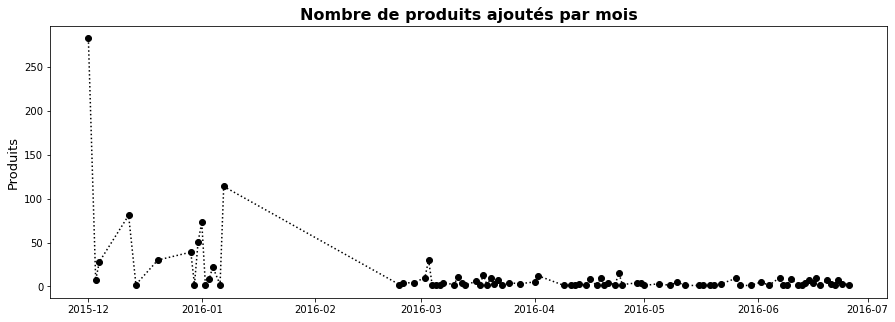

In [16]:
df_date = data.groupby(['crawl_timestamp'])['uniq_id'].count().reset_index()

plt.figure(figsize=(15, 5))
plt.plot(df_date['crawl_timestamp'], df_date['uniq_id'],
         marker='o', color='black', linestyle='dotted')
plt.xlabel('')
plt.ylabel('Produits')
plt.title("Nombre de produits ajoutés par mois")
plt.show()

In [17]:
# Fonction permettant de rajouter les étiquette en haut de chaque barre

def etiquette_v(ax, espace=5):
    """Ajoute les étiquettes en haut de chaque barre sur un barplot vertical.

    Arguments:
        ax (matplotlib.axes.Axes): objet matplotlib ocontenant les axes
            du plot à annoter.
        espace (int): distance entre les étiquettes et les barres.
    """

    # Pour chaque barre, placer une étiquette
    for rect in ax.patches:
        # Obtenir le placement de X et Y de l'étiquette à partir du rectangle
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Espace entre la barre et le label
        space = espace
        # Alignement vertical
        va = 'bottom'

        # Si la valeur est négative, placer l'étiquette sous la barre
        if y_value < 0:
            # Valeur opposer de l'argument espace
            space *= -1
            # Alignement vertical 'top'
            va = 'top'

        # Utiliser la valeur Y comme étiquette et formater avec 0 décimale
        label = "{:.0f}".format(y_value)

        # Créer l'annotation
        ax.annotate(
            label,
            (x_value, y_value),
            xytext=(0, space),
            textcoords="offset points",
            ha='center',
            va=va)

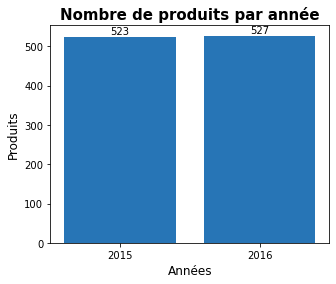

In [18]:
df_year = data.groupby(['year'])['uniq_id'].count().reset_index()

plt.figure(figsize=(5, 4))
ax = sns.barplot(x='year', y='uniq_id', data=df_year, color='#0f77ce')
plt.title('Nombre de produits par année', fontweight='bold', fontsize=15)
plt.xlabel("Années", fontsize=12)
plt.ylabel("Produits", fontsize=12)
etiquette_v(ax, 1)

<div class="alert alert-block alert-warning">
    <p>Lien internet des produits (url)</p>
</div>

In [19]:
data['product_url'].sample(3)

777                                  http://www.flipkart.com/rrtc-rrtc1105sm00-basic-analog-watch-women/p/itme4cp8tbp3zesd?pid=WATE4CP8CEDMSXEF
18                                     http://www.flipkart.com/franck-bella-fb74c-analog-watch-boys-men/p/itme9m3ruhhdgkqs?pid=WATE9M3RRRKZK4FD
694    http://www.flipkart.com/tallenge-christmas-collection-echoes-winter-gallery-wrap-canvas-painting/p/itmedzbhqafmgsdm?pid=PTGEDZBHZHGW2H4H
Name: product_url, dtype: object

In [20]:
data[['product_url', 'product_name', 'pid']].sample(3)

,product_url,product_name,pid
427,http://www.flipkart.com/smartpro-19-5v-3-9a-replacement-charger-vaio-series-vgn-cr540e-l-75-adapter/p/itmegz66qknwhahv?pid=ACCEGZ66HG5DH7ZH,"Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR540E/L 75 Adapter",ACCEGZ66HG5DH7ZH
255,http://www.flipkart.com/jaipan-kd2-5-kadhai-2-5-l/p/itme5wb8zwgaecrg?pid=PTPE5WB8Z2C6YYCQ,Jaipan KD2.5 Kadhai 2.5 L,PTPE5WB8Z2C6YYCQ
490,http://www.flipkart.com/hp-compaq-presario-cq43-6-cell-laptop-battery/p/itmdsy8emjhndp4y?pid=ACCDSY8EHJF6GRMG,HP Compaq Presario CQ43 6 Cell Laptop Battery,ACCDSY8EHJF6GRMG


Le lien renvoie vers le site e-commerce indien flipkart mais les produits ne sont plus disponibles car trop anciens. L'url est composée du nom du produit et de la variable pid. Ces deux variables ne seront pas conservées

<div class="alert alert-block alert-warning">
    <p>product_category_tree</p>
</div>

In [21]:
# 2 examples de product_category_tree
data['product_category_tree'].sample(2).tolist()

['["Watches >> Wrist Watches >> Perucci Wrist Watches"]',
 '["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]']

Nous remarquons que le product_category_tree possède plusieurs niveaux identifiables grâce au signe >> et que les produits ne possèdent pas tous le même nombre de niveaux. Nous allons créer x colonnes supplémentaires correspondant au nombre maximum de niveaux et splitter et affecter chaque niveau dans la bonne colonne.

In [22]:
def split_and_add_columns(df, var, sep):

    # Split des catégories en x colonnes
    df_cat = df[var].str.split(sep, expand=True)
    len_df_cat = len(df_cat.columns.tolist())

    # Modification automatique du nom des colonnes
    for i in range(0, len_df_cat):
        df_cat = df_cat.rename(columns={df_cat.columns[i]:
                                        'Cat_' + str(i)})

    # Assemblage des 2 dataframes
    df_new = pd.concat([df, df_cat], sort=False, axis=1)

    # Nettoyage des ["
    df_new.replace('\\["', '', regex=True, inplace=True)
    df_new.replace('"\\]', '', regex=True, inplace=True)

    return df_new

In [23]:
data = split_and_add_columns(data, 'product_category_tree', ' >> ')
data.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,year,Cat_0,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}",2016,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do...,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""key""=>""Type"", ""value""=>""Bath Towel""}, {""key""=>""GSM"", ""value""=>""500""}, {""key""=>""Model Name"", ""value""=>""Sathiyas cotton bath towel""}, {""key""=>""Ideal For"", ""value""=>""Men, Women, Boys, Girls""}, {""key""=>""Model ID"", ""value""=>""asvtwl322""}, {""key""=>""Color"", ""value""=>""Red, Yellow, Blue""}, {""key""=>""Size"", ""value""=>""Mediam""}, {""key""=>""Length"", ""value""=>""30 inch""}, {""key""=>""Width"", ""value""=>""60 inch""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""3""}, {""key""=>""Sales Package"", ""value""=>""3 Bath Towel""}]}",2016,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...",None,None


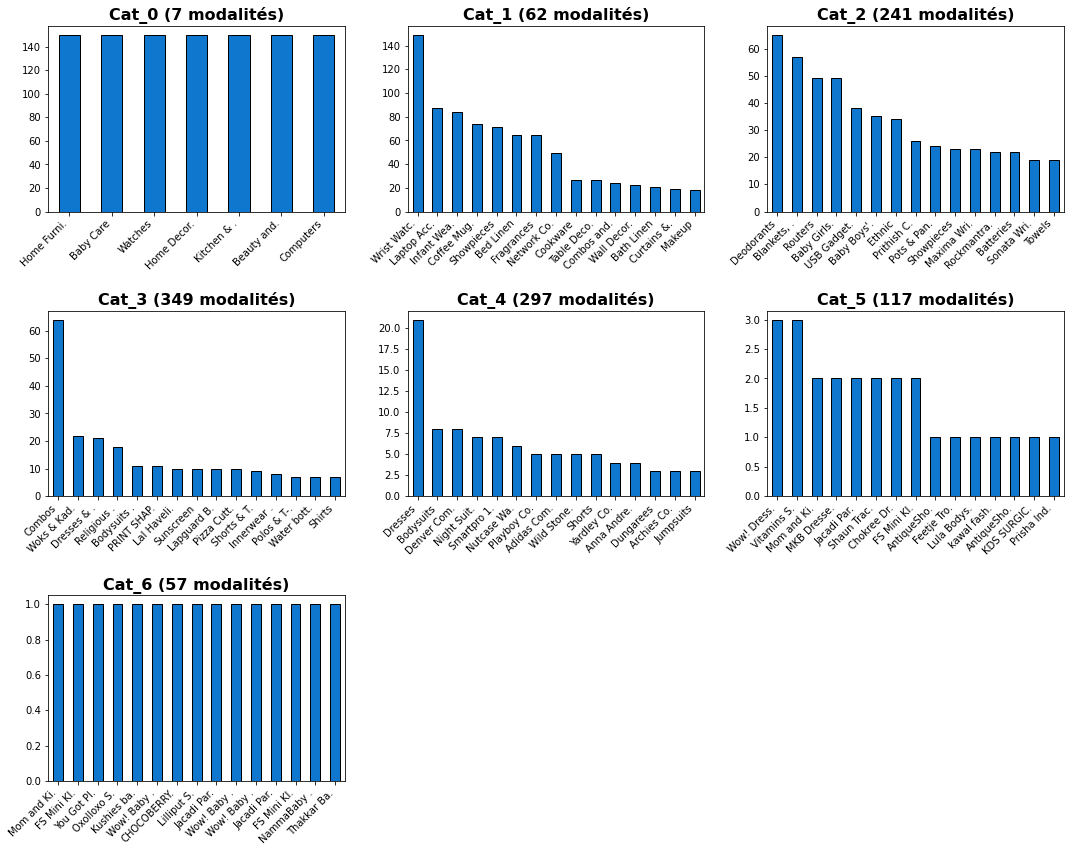

In [24]:
# Distribution des catégories
liste_categ = data.iloc[:, data.columns.str.startswith(
    'Cat')].columns.tolist()

fig = plt.figure(figsize=(15, 15))
for i, c in enumerate(liste_categ, 1):
    ax = fig.add_subplot(4, 3, i)
    modalites = data[c].value_counts()
    n_modalites = modalites.shape[0]

    if n_modalites > 15:
        modalites[0:15].plot.bar(color='#0f77ce', edgecolor='black', ax=ax)

    else:
        modalites.plot.bar(color='#0f77ce', edgecolor='black')

    ax.set_title(f'{c} ({n_modalites} modalités)', fontweight='bold')
    label = [item.get_text() for item in ax.get_xticklabels()]
    short_label = [lab[0:10] + '.' if len(lab) > 10 else lab for lab in label]
    ax.axes.set_xticklabels(short_label)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout(w_pad=2, h_pad=2)

- les produits comportent une catégorie principale et jusqu'à 6 sous-catégories supplémentaires
- seul le niveau principal Cat_0 comporte 7 catégories qui sont distribuées de manière homogène comportant chacunes 150 images

Nous allons donc utiliser le **Cat_0** pour la suite de nos analyses.

<div class="alert alert-block alert-warning">
    <p>image</p>
</div>

Il serait intéressant de vérifier que pour chaque produit de ce dataset, nous retrouvons bien sa photo dans le dosier image:

In [25]:
# images de la colonne image
image = []
for img in data['image']:
    image.append(img)

# images présentes dans le dossier Images
dossier_image = []
for photo in os.listdir('data/Images'):
    dossier_image.append(photo)

In [26]:
# Eléments uniques de la colonne image
difference_1 = set(image).difference(set(dossier_image))

# Eléments uniques du dossier Images
difference_2 = set(dossier_image).difference(set(image))

print(f'Image uniquement dans la colonne image: \n {difference_1}')
print('------------------------------------------------------------------')
print(f'Image uniquement dans le dossier Images: \n {difference_2}')

Image uniquement dans la colonne image: 
 set()
------------------------------------------------------------------
Image uniquement dans le dossier Images: 
 set()


Tous les produits ont bien une image associée.

<div class="alert alert-block alert-warning">
    <p>brand</p>
</div>

La marque semble être en première position du product_name:

In [27]:
data[['product_name', 'brand']].sample(3)

,product_name,brand
246,Peacock Kadhai 3.8 L,Peacock
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker,Uberlyfe
398,Netgear D3600 N600 Dual Band Gigabit Wi-Fi Modem Router,Netgear


Nous allons extraire le premier élément du product_name et le comparer à la marque afin de vérifier notre constat. Nous filtrons d'abord le dataset sur les lignes où la marque est indiquée.

In [28]:
# Filtre sur les marques non nulles
df_brand = data[~data['brand'].isna()]

# Création de 2 listes avec le 1er élément des colonnes product_name et brand
l1 = [i.split(' ')[0] for i in df_brand['product_name'].tolist()]
l2 = [i.split(' ')[0] for i in df_brand['brand'].tolist()]

In [29]:
# Eléments uniques de la liste brand
difference_2 = set(l2).difference(set(l1))

print(f'Marques uniquement dans la colonne brand: \n {difference_2}')

Marques uniquement dans la colonne brand: 
 {'Mega', 'Shoperite', 'Urban', 'STYLE'}


La quasi totalité des marques est reprise dans le nom du produit.

<div class="alert alert-block alert-warning">
    <p>Observations</p>
</div>

Le fichier est composé de 1050 lignes et 15 colonnes et comporte peu de données manquantes (sauf sur la variable brand). Il n'y a aucun doublon. Les produits ont été rajoutés entre le 01 décembre 2015 et le 26 juin 2016, équitablement entre les deux années et de manière plus régulière depuis mars 2016. Chaque produit est illustré par une image, possède une description et est associé à une catégorie principale et des catégories secondaires. Seule la catégorie principale sera utilisée dans la suite de ce projet afin d'avoir un jeu de données équilibré.

Les colonnes qui vont nous intéresser sont:
- **uniq_id et product_name** => identifiants uniques du produit
- **Cat_0** => catégorie la plus équilibrée (150 produits par catégorie)
- **image** => nom de l'image associée au produit présente dans le dossier Images
- **description** => pour choisir la catégorie à laquelle affecter le produit

Les colonnes suivantes ne seront pas conservées:
- **crawl_timestamp** => ne permet pas d'identifier un produit
- **product_url** => le lien ne fonctionne pas et cette rubrique est constituée des variables product_name et pid
- **pid** => pas d'information sur cette variable et non précise
- **brand** => marque du produit pouvant aider à son identification
- **retail_price et discounted_price** => pourrait permettre de classer un produit en fonction de son prix mais ce n'est pas le travail demandé ici
- **is_FK_Advantage_product** => ne permet pas d'identifier un produit
- **product_rating et overall_rating** => ne permet pas d'identifier un produit
- **product_specifications** => redondant avec la colonne description et moins complet

In [30]:
# Dataset réduit
data_txt = data[['uniq_id', 'product_name',
                 'Cat_0', 'description',
                 'image']]
data_txt.head(2)

,uniq_id,product_name,Cat_0,description,image
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,Home Furnishing,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Baby Care,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",7b72c92c2f6c40268628ec5f14c6d590.jpg


## Nettoyage des données textuelles <a class="anchor" id="txt"></a>

La première étape du traitement des données est de récupérer le corpus de textes, de faire une analyse exploratoire afin de bien comprendre les spécificités du jeu de données, et de nettoyer les données afin de pouvoir les utiliser ultérieurement dans nos algorithmes.

- le **corpus** : un ensemble de documents (ici la colonne description), regroupés dans une optique ou dans une thématique précise
- un **document** : la notion de document fait référence à un texte appartenant au corpus, mais indépendant des autres textes. Il peut être constitué d'une ou plusieurs phrases, un ou plusieurs paragraphes (ici chaque cellule de la colonne description)
- un **token** : le terme token désigne généralement un mot et/ou un élément de ponctuation
- le **vocabulaire** : il s'agit de l'ensemble des tokens distincts présents dans l'ensemble du corpus

#### Corpus

Nous récupérons dans un premier temps le corpus (colonne description) et effectuons un premier traitement de ce dernier pour avoir des données textuelles exploitables (au format string).

In [31]:
corpus_des = ' '.join([txt for txt in data_txt["description"]])
corpus_des[0:1000]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

#### Tokenization

Il s'agit du découpage en mots des différents documents qui constituent le corpus (la colonne description).
Dans un premier temps, on souhaite étudier le vocabulaire utilisé dans les descriptions par catégorie. Pour une première intuition, il est judicieux d'observer le nombre de mots utilisés.

Explication du regex utilisé:
- r => case sensitive
- \w => lettres et chiffres (équivalent à [a-zA-Z0-9_])
- "+" => caractère présent autant de fois que possible

In [32]:
corpus_token = RegexpTokenizer(r"\w+").tokenize(corpus_des)
print(corpus_token[0:300])

['Key', 'Features', 'of', 'Elegance', 'Polyester', 'Multicolor', 'Abstract', 'Eyelet', 'Door', 'Curtain', 'Floral', 'Curtain', 'Elegance', 'Polyester', 'Multicolor', 'Abstract', 'Eyelet', 'Door', 'Curtain', '213', 'cm', 'in', 'Height', 'Pack', 'of', '2', 'Price', 'Rs', '899', 'This', 'curtain', 'enhances', 'the', 'look', 'of', 'the', 'interiors', 'This', 'curtain', 'is', 'made', 'from', '100', 'high', 'quality', 'polyester', 'fabric', 'It', 'features', 'an', 'eyelet', 'style', 'stitch', 'with', 'Metal', 'Ring', 'It', 'makes', 'the', 'room', 'environment', 'romantic', 'and', 'loving', 'This', 'curtain', 'is', 'ant', 'wrinkle', 'and', 'anti', 'shrinkage', 'and', 'have', 'elegant', 'apparance', 'Give', 'your', 'home', 'a', 'bright', 'and', 'modernistic', 'appeal', 'with', 'these', 'designs', 'The', 'surreal', 'attention', 'is', 'sure', 'to', 'steal', 'hearts', 'These', 'contemporary', 'eyelet', 'and', 'valance', 'curtains', 'slide', 'smoothly', 'so', 'when', 'you', 'draw', 'them', 'apart'

In [33]:
def nb_tokens(txt):
    print("Nombre de tokens: {}".format(len(txt)))
    print("Nombre de tokens uniques: {}".format(len(set(txt))))

In [34]:
nb_tokens(corpus_token)

Nombre de tokens: 81563
Nombre de tokens uniques: 7670


- On retrouve des nombres seuls ou accolés à un mot (Duster25, 213...)
- Les mêmes mots peuvent avoir une majuscule ou non
- Certains mots n'apportent aucune précision et doivent être écartés: to, the, and etc
- La langue utilisée est l'anglais

#### Normalisation

Le fait d'essayer d'harmoniser les tokens est un processus nommé « normalisation ». Nous allons ici:
- passer le texte en minuscule,
- supprimer les espaces avant et après chaque token,
- récupérer les caractères alphanumériques (les caractères spéciaux / ponctuation ne seront pas pris),
- filtrer les "Stop Words" (mots à ignorer tels que: in, of, the...),
- ne garder que les tokens ayant 2 lettres ou plus
- ne garder que les lettres 

Toutes ces étapes seront intégrées dans une même fonction.

In [35]:
def clean_txt_1(text,
                stop_words="english",
                min_len_word=2,
                only_alpha=True):
    
    '''Natural Language Processing basic function.

    positional arguments:
    ------------------------
    text: str: text in a str format to process

    opt args:
    ------------------------
    stop_words : str: language of the stopwords
    min_len_word : int : the minimum length of words to keep
    only_alpha : bool : if True, exclude all tokens with a numeric character

    return:
    ------------------------
    a list of tokens'''

    # lower and strip
    doc = text.lower().strip()

    # Tokenize
    # tokenizer = RegexpTokenizer("[A-Za-z0-9]\w+")
    # tokenizer = RegexpTokenizer("[A-Za-z]\w+")
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Remove stopwords
    stop_words = set(stopwords.words(stop_words))
    clean_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Keep only len word > N
    more_than_N = [w for w in clean_tokens_list if len(w) >= min_len_word]

    # Keep only alpha not num
    if only_alpha == True:
        alpha_num = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_num = more_than_N

    return alpha_num

In [36]:
corpus_norm = clean_txt_1(corpus_des)
print(corpus_norm[0:300])

['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'rs', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'features', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'makes', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'designs', 'surreal', 'attention', 'sure', 'steal', 'hearts', 'contemporary', 'eyelet', 'valance', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moments', 'joyous', 'beauty', 'given', 'soothing', 'prints', 'bring', 'home', 'elegant', 'curtain', '

In [37]:
nb_tokens(corpus_norm)

Nombre de tokens: 55067
Nombre de tokens uniques: 4881


Regardons à présent la fréquence d'apparition des mots:

In [38]:
freq_words = collections.Counter(corpus_norm)
freq_words = pd.DataFrame.from_dict(freq_words,
                                    orient='index').rename(
    columns={0:'Occurences'}).reset_index()
freq_words = freq_words.sort_values(by='Occurences',
                                    ascending=False).reset_index(drop=True)
freq_words.head(20)

,index,Occurences
0,rs,911
1,products,631
2,free,618
3,buy,581
4,delivery,567
5,cash,564
6,shipping,564
7,genuine,564
8,replacement,559
9,cm,543


On note que certains mots sont inutiles et ne vont pas permettre la classification des produits dans des catégories. Ils n'apportent pas de valeur informative pour la compréhension du "sens" d'un document et corpus. C'est le cas des premiers mots les plus fréquents. Nous allons les considérer comme des stopwords et les supprimer de notre corpus:

In [39]:
# Mots à supprimer:
newStopWords = freq_words['index'].iloc[0:18].tolist()
print(newStopWords)

['rs', 'products', 'free', 'buy', 'delivery', 'cash', 'shipping', 'genuine', 'replacement', 'cm', 'day', 'flipkart', 'com', 'guarantee', 'online', 'features', 'specifications', 'price']


In [40]:
# Corpus retraité des mots inutiles
corpus_norm = [w for w in corpus_norm if w not in newStopWords]

In [41]:
# Vérification des 30 mots les plus fréquents
print(collections.Counter(corpus_norm).most_common(30))

[('watch', 330), ('color', 328), ('mug', 327), ('baby', 320), ('pack', 317), ('material', 312), ('set', 310), ('type', 304), ('cotton', 299), ('box', 292), ('general', 288), ('package', 269), ('analog', 262), ('sales', 261), ('number', 253), ('warranty', 250), ('quality', 245), ('details', 235), ('product', 233), ('brand', 232), ('best', 230), ('model', 226), ('design', 225), ('ceramic', 219), ('key', 215), ('laptop', 214), ('fabric', 211), ('prices', 209), ('showpiece', 206), ('made', 189)]


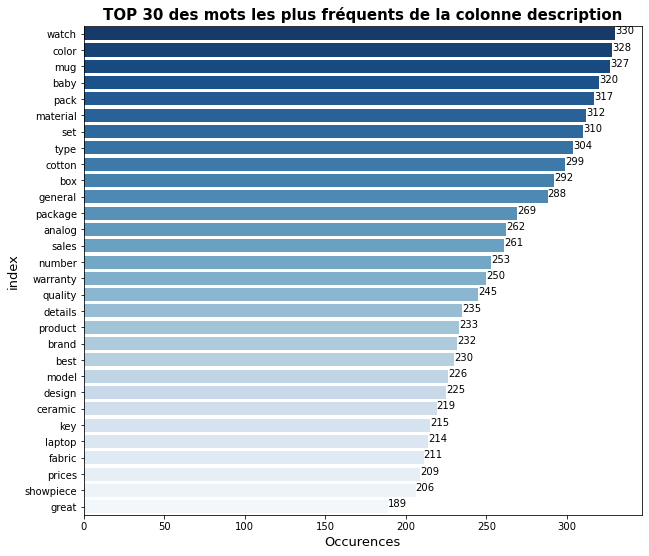

In [42]:
freq_words = freq_words[18:]

plt.figure(figsize=(10, 9))
ax = sns.barplot(y='index',
                 x='Occurences',
                 data=freq_words.head(30),
                 palette='Blues_r')
plt.title('TOP 30 des mots les plus fréquents de la colonne description',
          fontweight='bold',
          fontsize=15)

total = len(freq_words['index'].iloc[0:30])
for p in ax.patches:
    etiquette = '{:,.0f}'.format(p.get_width())
    width, height = p.get_width(), p.get_height()
    x = p.get_x()+width+0.02
    y = p.get_y()+height/2
    ax.annotate(etiquette, (x, y))

Voyons maintenant les mots les moins présents:

In [43]:
token_nb = pd.Series(corpus_norm).value_counts()
token_nb.describe()

count    4863.000000
mean        9.353486
std        26.576912
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       330.000000
dtype: float64

La distributions des tokens est asymétrique avec 50% des tokens présents 2 fois, 75% des tokens présents 6 fois avec un maximum de 330 fois. Comme il y a de grandes chances que lors de la réduction de dimension ces tokens soient écartés, supprimons les dès à présent.

In [44]:
# Liste des mots uniques
list_unique_words = token_nb[token_nb == 1]
list_unique_words[:20]

dropping        1
mx              1
acer            1
structure       1
covering        1
liabilities     1
oppurtunity     1
loss            1
derivatives     1
wowan           1
ingress         1
lightening      1
creases         1
flatware        1
existing        1
robinson        1
numbers         1
entertaining    1
ms              1
narmal          1
dtype: int64

In [45]:
# Nombre de mots uniques
len(list_unique_words)

1436

In [46]:
# Sauvegarde des mots qui apparaissent une fois dans le corpus
# list_unique_words = pd.DataFrame({"words" : list_unique_words})
# list_unique_words.to_csv('data/unique_words.csv', index=False)

Nous allons rajouter à notre fonction la possibilité de supprimer une liste de mots à considérer comme des stopwords et une liste de mots qui n'apparaissent que x fois dans le corpus:

In [47]:
def clean_txt_2(text,
                stop_words="english",
                min_len_word=2,
                only_alpha=True,
                extra_words=None,
                list_rare_words=None):
    
    '''Natural Language Processing basic function.
    
    positional arguments:
    ------------------------
    text: str: text in a str format to process
    
    opt args:
    ------------------------
    stop_words : str: language of the stopwords
    min_len_word : int : the minimum length of words to keep
    only_alpha : bool : if True, exclude all tokens with a numeric character
    extra_words : list : words to exclude and consider as stopwords
    list_rare_words : list : list of rare words to exclude
    
    return:
    ------------------------
    a list of tokens'''

    # extra_words
    if not extra_words:
        extra_words = []

    # list_rare_words
    if not list_rare_words:
        list_rare_words = []

    # lower and strip
    doc = text.lower().strip()

    # Tokenize
    # tokenizer = RegexpTokenizer("[A-Za-z0-9]\w+")
    # tokenizer = RegexpTokenizer("[A-Za-z]\w+")
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Remove stopwords
    # stop_words = list(set(stopwords.words(stop_words)))
    stop_words = set(stopwords.words(stop_words))
    clean_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Keep only len word > N
    more_than_N = [w for w in clean_tokens_list if len(w) >= min_len_word]

    # Keep only alpha not num
    if only_alpha == True:
        alpha_num = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_num = more_than_N

    # Drop extra_words tokens
    extra_w = [w for w in alpha_num if w not in extra_words]
    
    # No rare tokens
    non_rare_tokens = [w for w in extra_w if w not in list_rare_words]

    return non_rare_tokens

In [48]:
corpus_norm = clean_txt_2(corpus_des,
                          stop_words="english",
                          min_len_word=2,
                          only_alpha=True,
                          extra_words=newStopWords,
                          list_rare_words=list_unique_words.index.tolist())
print(corpus_norm[0:300])

['key', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'makes', 'room', 'environment', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'give', 'home', 'bright', 'appeal', 'designs', 'attention', 'sure', 'contemporary', 'eyelet', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'evening', 'create', 'special', 'moments', 'beauty', 'given', 'soothing', 'prints', 'bring', 'home', 'elegant', 'curtain', 'light', 'room', 'get', 'right', 'amount', 'sunlight', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'ge

In [49]:
nb_tokens(corpus_norm)

Nombre de tokens: 44050
Nombre de tokens uniques: 3427


#### Lemmatization

Le processus de « lemmatisation » consiste à représenter les mots sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. L'idée étant encore une fois de ne conserver que le sens des mots utilisés dans le corpus.

In [50]:
lemmatizer = WordNetLemmatizer()
corpus_token_lem = [lemmatizer.lemmatize(w) for w in corpus_norm]
print(corpus_token_lem[0:300])

['key', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environment', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'give', 'home', 'bright', 'appeal', 'design', 'attention', 'sure', 'contemporary', 'eyelet', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'evening', 'create', 'special', 'moment', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'light', 'room', 'get', 'right', 'amount', 'sunlight', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'general',

In [51]:
nb_tokens(corpus_token_lem)

Nombre de tokens: 44050
Nombre de tokens uniques: 3155


#### Fonction globale de traitement du texte

Afin de pouvoir analyser les mots principaux par catégorie puis appliquer ensuite la réduction de dimension puis le clustering, appliquons nos étapes de nettoyage par ligne de la colonne description. Mettons tout d'abord à jour notre fonction de nettoyage en rajoutant la possibilité de lemmatiser ou de stemmatiser, de ne retourner que des mots anglais et de retourner non pas une liste mais une chaine de caractère:

In [52]:
eng_words = [i.lower() for i in words.words()]
lm = WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]

In [53]:
def clean_txt_3(text,
                join=True,
                lemm_or_stemm=None,
                stop_words="english",
                eng_words=None,
                min_len_word=2,
                only_alpha=True,
                extra_words=None,
                list_rare_words=None):
    
    '''Natural Language Processing basic function.

    positional arguments:
    ------------------------
    text: str: text in a str format to process

    opt args:
    ------------------------
    join : bool : if True, return a string else return the list of tokens
    lemm_or_stemm : str : if lemm do lemmentize else stemmentize
    stop_words : str: language of the stopwords
    eng_words : list : list of english words
    min_len_word : int : the minimum length of words to keep
    only_alpha : bool : if True, exclude all tokens with a numeric character
    extra_words : list : words to exclude and consider as stopwords
    list_rare_words : list : list of rare words to exclude

    return:
    ------------------------
    a list of tokens'''

    # extra_words
    if not extra_words:
        extra_words = []

    # eng_words
    if not eng_words:
        eng_words = []

    # list_rare_words
    if not list_rare_words:
        list_rare_words = []

    # lower and strip
    doc = text.lower().strip()

    # Tokenize
    # tokenizer = RegexpTokenizer("[A-Za-z0-9]\w+")
    # tokenizer = RegexpTokenizer("[A-Za-z]\w+")
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Remove stopwords
    # stop_words = list(set(stopwords.words(stop_words)))
    stop_words = set(stopwords.words(stop_words))
    clean_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Drop extra_words tokens
    extra_w = [w for w in clean_tokens_list if w not in extra_words]

    # No rare tokens
    non_rare_tokens = [w for w in extra_w if w not in list_rare_words]

    # Keep only len word > N
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # Keep only alpha not num
    if only_alpha == True:
        alpha_num = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_num = more_than_N

    # Stemm or Lemm
    if lemm_or_stemm == "lemm":
        trans = WordNetLemmatizer()
        trans_txt = [trans.lemmatize(i) for i in alpha_num]
    elif lemm_or_stemm == "stemm":
        trans = PorterStemmer()
        trans_txt = [trans.stem(i) for i in alpha_num]
    else:
        trans_txt = alpha_num

    # English words
    if eng_words:
        engl_txt = [i for i in trans_txt if i in eng_words]
    else:
        engl_txt = trans_txt
        
    # Return a list or a string
    if join:
        return " ".join(engl_txt)

    return engl_txt

#### Nettoyage des colonnes description et product_name

In [54]:
# Colonne description nettoyée et lemmatisée
list_rare_words = list_unique_words.index.tolist()

data_txt['desc_clean_lem'] = [clean_txt_3(
    row,
    join=True,
    lemm_or_stemm="lemm",
    stop_words="english",
    eng_words=None,
    min_len_word=2,
    only_alpha=True,
    extra_words=newStopWords,
    list_rare_words=list_rare_words) for row in data_txt['description']]

C:\Users\milie\AppData\Local\Temp\ipykernel_12564\3906961592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt['desc_clean_lem'] = [clean_txt_3(


In [55]:
# Colonne description nettoyée et non lemmatisée
data_txt['desc_clean'] = [clean_txt_3(
    row,
    join=True,
    lemm_or_stemm=None,
    stop_words="english",
    eng_words=None,
    min_len_word=2,
    only_alpha=True,
    extra_words=newStopWords,
    list_rare_words=list_rare_words) for row in data_txt['description']]

C:\Users\milie\AppData\Local\Temp\ipykernel_12564\703745362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt['desc_clean'] = [clean_txt_3(


In [56]:
# 5 exemples
data_txt[['description', 'desc_clean_lem', 'desc_clean']].sample(5)

,description,desc_clean_lem,desc_clean
174,Buy Prithish Independence Day Design 9 Double Color Ceramic Mug for Rs.225 online. Prithish Independence Day Design 9 Double Color Ceramic Mug at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,prithish independence design double color ceramic mug prithish independence design double color ceramic mug best price,prithish independence design double color ceramic mug prithish independence design double color ceramic mug best prices
460,"Key Features of Beebay Baby Girl's Fit and Flare Dress Coral Fit and Flare,Beebay Baby Girl's Fit and Flare Dress Price: Rs. 845 Cute schiffli embroidery coral lace dress with cotton woven fabric in this summer .Frill at bottom and back button opening for easy wear.,Specifications of Beebay Baby Girl's Fit and Flare Dress Dimensions Length Midi/Knee Length General Details Pattern Embroidered Ideal For Baby Girl's Occasion Casual Dress Details Sleeve Sleeveless Belt Included No Number of Contents in Sales Package Pack of 1 Fabric 100% Cotton Type Fit and Flare Fabric Care Machine wash",key beebay baby girl fit flare dress coral fit flare beebay baby girl fit flare dress cute embroidery coral lace dress cotton woven fabric summer bottom back button opening easy wear beebay baby girl fit flare dress dimension length midi knee length general detail pattern embroidered ideal baby girl occasion casual dress detail sleeve sleeveless belt included number content sale package pack fabric cotton type fit flare fabric care machine wash,key beebay baby girl fit flare dress coral fit flare beebay baby girl fit flare dress cute embroidery coral lace dress cotton woven fabric summer bottom back button opening easy wear beebay baby girl fit flare dress dimensions length midi knee length general details pattern embroidered ideal baby girl occasion casual dress details sleeve sleeveless belt included number contents sales package pack fabric cotton type fit flare fabric care machine wash
453,"Bed & Bath Cotton Floral Double Bedsheet (1 Bedsheet, 2 Pillow Covers, Purple, Green, Beige)\r\n Price: Rs. 1,960\r\n\t\t\t\t\r\n\t\t\tSuperb Quality And Dat So Comfortable Feelin Is Hilton Series. Lovely Prints And Pure Cotton Bedsheets Should Surely Be Welcomed In Your Room This Summer\r\nSuperb Quality And Dat So Comfortable Feelin Is Hilton Series. Lovely Prints And Pure Cotton Bedsheets Should Surely Be Welcomed In Your Room This Summer",bed bath cotton floral double bedsheet bedsheet pillow cover purple green beige superb quality dat comfortable feelin hilton series lovely print pure cotton bedsheets surely welcomed room summer superb quality dat comfortable feelin hilton series lovely print pure cotton bedsheets surely welcomed room summer,bed bath cotton floral double bedsheet bedsheet pillow covers purple green beige superb quality dat comfortable feelin hilton series lovely prints pure cotton bedsheets surely welcomed room summer superb quality dat comfortable feelin hilton series lovely prints pure cotton bedsheets surely welcomed room summer
570,"Now Q710-SOS07 NOW Analog Watch - For Girls - Buy Now Q710-SOS07 NOW Analog Watch - For Girls Q710-SOS07 Online at Rs.695 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!",analog watch girl analog watch girl india great discount,analog watch girls analog watch girls india great discounts
473,"Key Features of Allin Exporters Fennel Oil (Co2 Extract) Ideal For: Men, Women Application Area: All Skin Type: Combination Skin Organic Type: Organic,Allin Exporters Fennel Oil (Co2 Extract) (30 ml) Price: Rs. 649 Obtained through the method of Supercritical Fluid or Co2 extraction process from the seeds of fennel plant, fennel oil extract bears a sweet, spicy, and woody aroma. In ancient times, it was considered to the symbol of courage, longevity, and strength. This oil extract is ideal for getting 

Visualisons sous la forme d'un nuage les mots principaux par catégorie de produits (colonne desc_clean_lem):

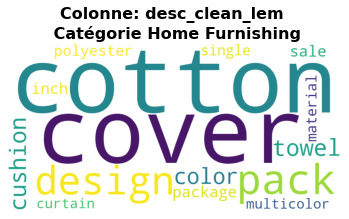

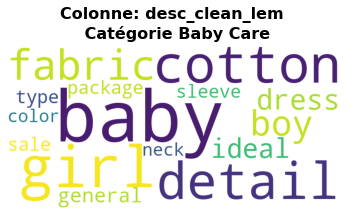

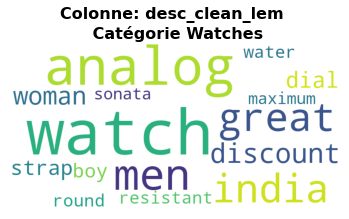

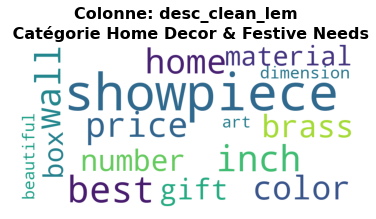

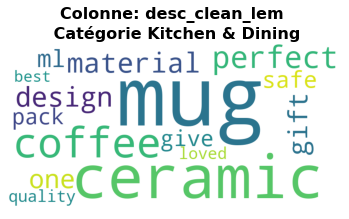

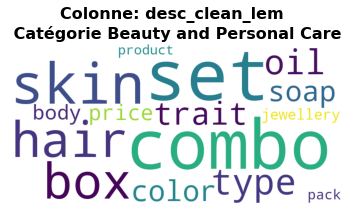

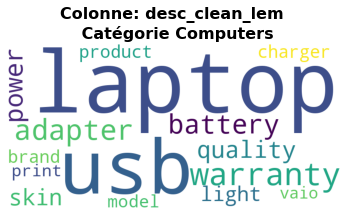

In [57]:
for mod in data_txt['Cat_0'].unique():
    df = data_txt[data_txt['Cat_0'] == mod]
    corp = ' '.join([txt for txt in df["desc_clean_lem"]])
    corp_token = nltk.word_tokenize(corp)
    wcdict = collections.Counter(corp_token)
    wordcloud = WordCloud(background_color='white',
                          max_words=15,
                          width=800,
                          height=400).generate_from_frequencies(wcdict)

    plt.figure(figsize=(6, 5))
    plt.imshow(wordcloud)
    plt.title(f"Colonne: desc_clean_lem \n Catégorie {mod}")
    plt.axis("off")

Nous allons également appliquer notre nettoyage de texte aux noms des produits:

In [58]:
# Colonne product_name nettoyée et lemmatisée
data_txt['pname_clean_lem'] = [clean_txt_3(
    row,
    join=True,
    lemm_or_stemm="lemm",
    stop_words="english",
    eng_words=None,
    min_len_word=2,
    only_alpha=True,
    extra_words=newStopWords,
    list_rare_words=list_rare_words) for row in data_txt['product_name']]

C:\Users\milie\AppData\Local\Temp\ipykernel_12564\1546224162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt['pname_clean_lem'] = [clean_txt_3(


In [59]:
# Colonne product_name nettoyée et non lemmatisée
data_txt['pname_clean'] = [clean_txt_3(
    row,
    join=True,
    lemm_or_stemm=None,
    stop_words="english",
    eng_words=None,
    min_len_word=2,
    only_alpha=True,
    extra_words=newStopWords,
    list_rare_words=list_rare_words) for row in data_txt['product_name']]

C:\Users\milie\AppData\Local\Temp\ipykernel_12564\671406072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt['pname_clean'] = [clean_txt_3(


In [60]:
# 5 exemples de noms de produits
data_txt[['product_name', 'pname_clean', 'pname_clean_lem']].sample(5)

,product_name,pname_clean,pname_clean_lem
908,Cotton On Kids Baby Boy's Printed Casual Shirt,cotton kids baby boy printed casual shirt,cotton kid baby boy printed casual shirt
542,Maxima 01741LPLN Analog Watch - For Women,maxima analog watch women,maximum analog watch woman
320,"Layer'r Shot Compact Impact ,Explode And Turbo Body Spray (Pack Of 3) Combo Set",layer compact turbo body spray pack combo set,layer compact turbo body spray pack combo set
725,Craftartz Buddha Brass Idol Dhyan Mudra Showpiece - 14 cm,buddha brass idol showpiece,buddha brass idol showpiece
65,Shopmania Happy Birthday Gift For Starting Letter G Ceramic Mug,shopmania happy birthday gift starting letter ceramic mug,shopmania happy birthday gift starting letter ceramic mug


Visualisons maintenant sous la forme d'un nuage les mots principaux par nom de produit (colonne pname_clean_lem):

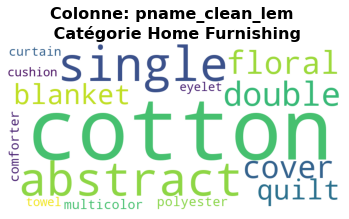

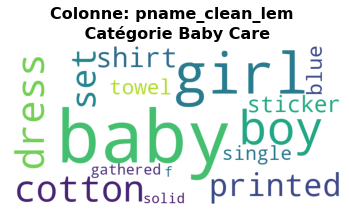

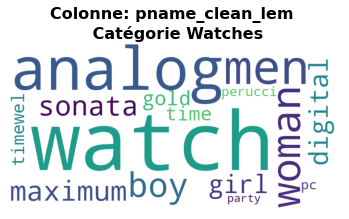

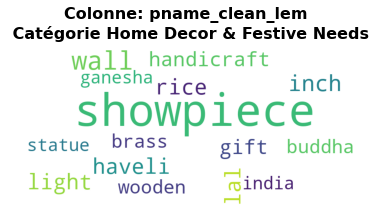

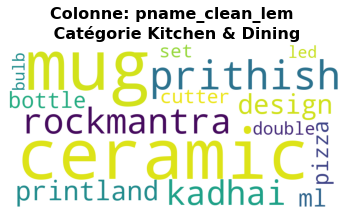

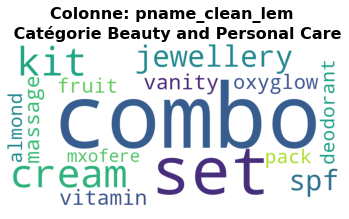

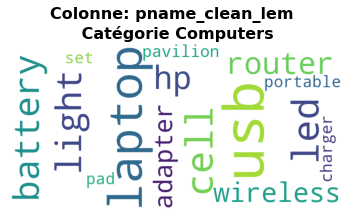

In [61]:
for mod in data_txt['Cat_0'].unique():
    df = data_txt[data_txt['Cat_0'] == mod]
    corp = ' '.join([txt for txt in df["pname_clean_lem"]])
    corp_token = nltk.word_tokenize(corp)
    wcdict = collections.Counter(corp_token)
    wordcloud = WordCloud(background_color='white',
                          max_words=15,
                          width=800,
                          height=400).generate_from_frequencies(wcdict)

    plt.figure(figsize=(6, 5))
    plt.imshow(wordcloud)
    plt.title(f"Colonne: pname_clean_lem \n Catégorie {mod}")
    plt.axis("off")

In [62]:
data_bow = data_txt.copy()

## Extraction de l'information du texte <a class="anchor" id="extract"></a>

Nous allons maintenant étudier comment **extraire l'information du texte pour le traitement ultérieur par des modèles de machine learning**. En d'autres termes, nous cherchons une **représentation du langage pour un modèle statistique** qui vise à exploiter des données textes.

### Approches de type bag of word <a class="anchor" id="bag"></a>

Le bag-of-words (sac de mots en français) consiste principalement à nettoyer les données textuelles d’une certaine manière afin de pouvoir ensuite les fournir en entrée de modèles d’apprentissage automatique.

Bien que son usage ait diminué, cette technique possède de nombreux atouts:
- très simple à comprendre
- peut être utilisé sur un faible échantillon de données alors que les techniques basées sur les réseaux de neurones ont en besoin d’énormément
- ne nécessite pas de capacités de calcul importantes (un CPU suffit alors que les techniques de réseaux de neurones nécessitent des GPUs ou des TPUs qui coûtent extrêmement chers)

Les algorithmes d’apprentissage automatique ne peuvent pas fonctionner directement avec du texte brut. **Le texte doit être converti en chiffres et notamment en vecteur. Un bag-of-words est une représentation du texte qui décrit la présence de mots dans un document**. Cela implique deux choses :
- un vocabulaire de mots connus
- une mesure de la présence des mots connus

Il s’agit d’un « sac » de mots, car toute information sur l’ordre ou la structure des mots dans le document est rejetée. Le modèle se préoccupe seulement de savoir si des mots connus se trouvent dans le document et non pas où ils se trouvent dans le document. Ainsi, le bag-of-words élimine toute l’information relative à l’ordre des mots et **met l’accent sur l’occurrence des mots dans un document**. **L’intuition est que les documents sont similaires s’ils ont un contenu similaire**. De plus, du seul contenu nous pouvons apprendre quelque chose sur la signification du document.

#### Comptage simple de mots (Countvectorizer) <a class="anchor" id="cpte"></a>

Il est utilisé pour **transformer un texte donné en un vecteur sur la base de la fréquence (nombre) de chaque mot qui apparaît dans le texte entier**. Cette méthode est utile lorsque nous disposons de plusieurs textes de ce type et que nous souhaitons convertir chaque mot de chaque texte en vecteurs (pour les utiliser dans une analyse textuelle ultérieure).

CountVectorizer crée une matrice dans laquelle **chaque mot unique est représenté par une colonne de la matrice**, et **chaque échantillon de texte du document est une ligne de la matrice**. La valeur de chaque cellule n'est rien d'autre que le **nombre de mots** dans cet échantillon de texte particulier.

Voici les différentes étapes que nous allons suivre:
- **Countvectorizer** sur données lemmatisées avec **extraction des features de la colonne descriptio**n (desc_clean_lem)
- **Analyse en composantes principales** avec choix de l'hyperparamètre n_components en fonction de l'éboulis des valeurs propres
- **t-SNE** avec 2 composantes et optimisation de l'hyperparamètre perplexity
- **KMeans** avec 7 clusters pour représenter nos 7 catégories
- Calcul de l'**Adjusted Rand Index** (ARI) et **visualisation** en 2 dimensions des produits par catégories réelles vs produits par clusters
- Nous reproduirons ensuite toutes ces étapes sur données lemmatisées avec **extraction des features de la colonne product_name** (pname_clean_lem) et choisirons la méthode avec le meilleur ARI (.fit sur description ou sur product_name).
- Nous referons tourner notre modèle sur les données avec un **autre preprocessing** (données non lemmatisées) afin de voir le plus performant

##### Countvectorizer sur données lemmatisées avec extraction des features de la colonne description (desc_clean_lem)

<div class="alert alert-block alert-warning">
    <p>Countvectorizer</p>
</div>

In [63]:
def bag_of_word(df, df_index, feature_fit, feature_trans, model):
    # Initialisation
    mod = model
    # Extraction features du texte
    mod_fit = mod.fit(df[feature_fit])
    # Vectorisation (encodage du document)
    mod_transform = mod.transform(df[feature_trans])
    feat_names = mod.get_feature_names_out()
    #display(mod.vocabulary_)
    # Format DataFrame
    df = pd.DataFrame(mod_transform.toarray(),
                      index=df[df_index],
                      columns=feat_names) / len(feat_names)
    return df

Nous allons dans une premier temps créer une variable product_name_desc_clean qui sera la concaténation des features product_name_clean et desc_clean.

In [64]:
data_bow["pname_desc_clean_lem"] = \
    data_bow["pname_clean_lem"] + " " + data_bow["desc_clean_lem"]

Puis appliquer notre CountVectorizer qui aura extrait les features du texte de la colonne desc_clean_lem et encodera la variable pname_desc_clean_lem:

In [65]:
df_cvect_desc_lem = bag_of_word(data_bow,
                                'pname_clean_lem',
                                'desc_clean_lem',
                                'pname_desc_clean_lem',
                                CountVectorizer())

df_cvect_desc_lem

,aa,aapno,aari,ability,able,abode,abroad,absorbency,absorbent,absorbing,...,youth,youthful,yuva,zero,zinc,zingalalaa,zipper,zone,zora,zyxel
pname_clean_lem,,,,,,,,,,,,,,,,,,,,,
elegance polyester multicolor abstract eyelet door curtain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sathiyas cotton bath towel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eurospa cotton terry face towel set,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000317,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
santosh royal fashion cotton printed king sized double bedsheet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jaipur print cotton floral king sized double bedsheet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
empower extra large self adhesive sticker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wallmantra large vinyl sticker sticker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
uberlyfe extra large pigmented polyvinyl film imported sticker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-block alert-warning">
    <p>ACP</p>
</div>

L’ACP, l’analyse en composantes principales, s’intéresse à des tableaux de données rectangulaires avec en lignes des individus et en colonnes des variables qui sont de nature quantitative. Donc on peut considérer qu’on a I individus et K variables.

Cette analyse permet de résumer l’information de plusieurs variables quantitatives mesurées sur un ensemble d’individus afin d’étudier :

- Les individus: lesquels se ressemblent ?
- Les variables: lesquelles sont liées ? indépendantes ?

Cette analyse peut mener à une caractérisation de groupe d’individus.

L'ACP est définie comme une transformation linéaire orthogonale qui transforme les données dans un nouveau système de coordonnées de telle sorte que la plus grande variance par une certaine projection scalaire des données se situe sur la première coordonnée (appelée première composante principale), la deuxième plus grande variance sur la deuxième coordonnée, et ainsi de suite.

L'analyse en composantes principales (ACP) est une technique qui transforme les données à haute dimension en données à plus faible dimension tout en conservant le plus d'informations possible.

Ici, notre matrice contient 3153 colonnes, une réduction de dimension s'impose. Elle permettra d'améliorer les temps de calcul.

In [66]:
# Standardisation des données
scaler = StandardScaler()
cvect_desc_lem_std = scaler.fit_transform(df_cvect_desc_lem)
cvect_desc_lem_std

array([[-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       ...,
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877]])

In [67]:
# ACP
pca = PCA()
pca.fit(cvect_desc_lem_std)

PCA()

In [68]:
# Fonction qui affiche l'éboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

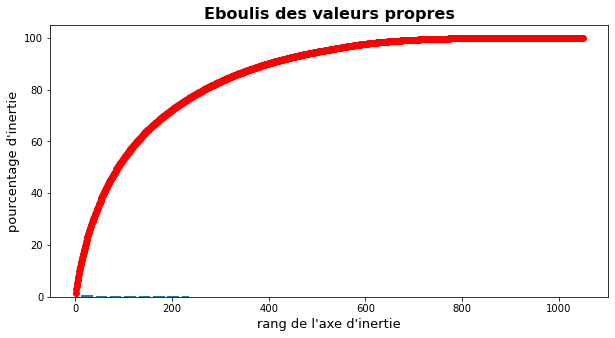

In [69]:
plt.figure(figsize=(10, 5))
display_scree_plot(pca)

Le graphique montre la quantité de variance capturée (sur l'axe des y) en fonction du nombre de composantes que nous incluons (sur l'axe des x). Une règle empirique consiste à préserver environ 80 % de la variance. Il faudrait donc garder 250 composantes.

Nous effectuons l'ACP avec le nombre de composantes choisi ci-dessus.

In [70]:
# ACP
pca = PCA(n_components=250)
pca.fit(cvect_desc_lem_std)

PCA(n_components=250)

Nous n'avons besoin que des scores calculés des composantes résultantes pour les éléments de notre ensemble de données :

In [71]:
pca_cvect_desc_lem = pca.transform(cvect_desc_lem_std)
pca_cvect_desc_lem

array([[ 3.86301271,  5.77407619,  1.09259681, ...,  0.39848513,
         0.7928463 ,  0.40687038],
       [-0.45298787, -0.12438776,  0.39522625, ...,  0.88821055,
        -0.8993072 ,  0.16375586],
       [ 3.98484254,  2.05997667,  1.20400088, ..., -2.18176682,
         1.18378157, -0.89956226],
       ...,
       [-1.56801576,  1.81558986, -1.01489535, ..., -1.15077665,
         1.81609636,  0.45337035],
       [-1.91125304, -0.75166904,  0.38866793, ...,  0.47093134,
        -0.15387583,  0.01146065],
       [-1.82662938, -0.32265324,  0.14530855, ...,  0.15126657,
         0.2567601 , -0.06047063]])

<div class="alert alert-block alert-warning">
    <p>t-SNE</p>
</div>

L'algorithme t-SNE (t-distributed stochastic neighbor embedding) est une technique de **réduction de dimension** pour la visualisation de données développée par Geoffrey Hinton et Laurens van der Maaten et publiée en 2008. 

Il s'agit d'une **méthode non linéaire permettant de représenter un ensemble de points d'un espace à grande dimension dans un espace de deux ou trois dimensions**. Les données peuvent ensuite être visualisées sous la forme d'un nuage de points. L'algorithme t-SNE tente de trouver une configuration optimale selon un critère de théorie de l'information afin de conserver la proximité entre les points pendant la transformation : deux points qui sont proches (resp. éloignés) dans l'espace d'origine doivent être proches (resp. éloignés) dans l'espace de faible dimension.

Il n'y a pas de règle spécifique pour déterminer les valeurs absolues des hyperparamètres comme la perplexité et le nombre d'itérations, cela dépend du jeu de données. Nous devrons donc exécuter t-SNE à plusieurs reprises avec différentes valeurs d'hyperparamètres avant d'arriver à un graphique approprié pour la visualisation.

<div class="alert alert-block alert-info">
    <p>comprends pas code pour y_cat_num</p>
</div>

In [72]:
# Liste des catégories
categ_list = list(set(data_bow['Cat_0']))
print("catégories : ", categ_list)
y_cat_num = [(1-categ_list.index(data_bow.iloc[i]['Cat_0'])) for i in range(len(data_bow))]

catégories :  ['Kitchen & Dining', 'Watches', 'Computers', 'Home Furnishing', 'Baby Care', 'Beauty and Personal Care', 'Home Decor & Festive Needs']


In [73]:
# Représentation graphique du Tsne
def TSNE_visu(X_tsne, y_cat_num, labels) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=categ_list, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories')
    
    plt.show()

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


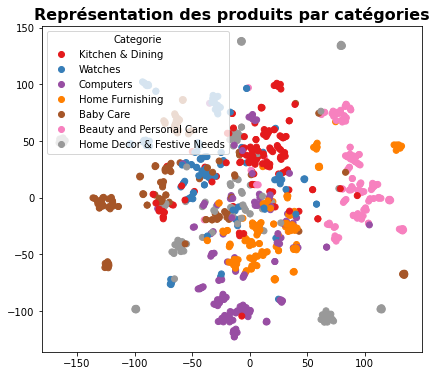

In [74]:
# Avec perplexity = 5 et n_iter = 5000
tsne_5 = manifold.TSNE(n_components=2,
                       perplexity=5,
                       n_iter=5000,
                       random_state=42)

tsne_5_cvect_desc_lem = tsne_5.fit_transform(pca_cvect_desc_lem)

TSNE_visu(tsne_5_cvect_desc_lem, y_cat_num, categ_list)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


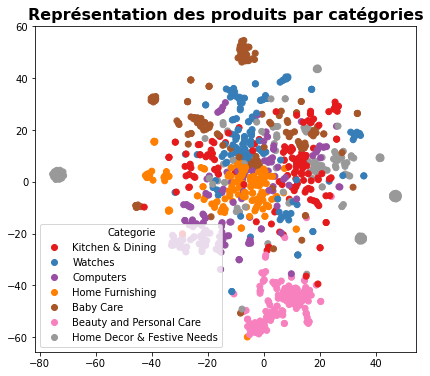

In [75]:
# Avec perplexity = 30 et n_iter = 5000
tsne_30 = manifold.TSNE(n_components=2,
                        perplexity=30,
                        n_iter=5000,
                        random_state=42)

tsne_30_cvect_desc_lem = tsne_30.fit_transform(pca_cvect_desc_lem)

TSNE_visu(tsne_30_cvect_desc_lem, y_cat_num, categ_list)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


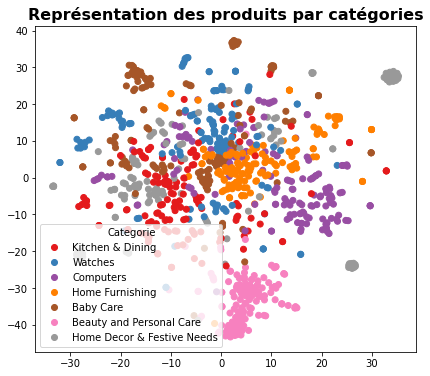

In [76]:
# Avec perplexity = 50 et n_iter = 5000
tsne_50 = manifold.TSNE(n_components=2,
                        perplexity=50,
                        n_iter=5000,
                        random_state=42)

tsne_50_cvect_desc_lem = tsne_50.fit_transform(pca_cvect_desc_lem)

TSNE_visu(tsne_50_cvect_desc_lem, y_cat_num, categ_list)

A la vue des 3 représentations à 2 dimensions, nous allons définir l'hyperparamètre perplexity à 30.

<div class="alert alert-block alert-warning">
    <p>KMeans</p>
</div>

In [77]:
# Initialisation du KMeans avec 7 clusters
kmeans_cvect_desc_lem = KMeans(n_clusters=7, init='k-means++', random_state=42)

In [78]:
# Kmeans sur données issues du t-SNE avec perplexity à 30
kmeans_cvect_desc_lem.fit(tsne_30_cvect_desc_lem)

KMeans(n_clusters=7, random_state=42)

In [79]:
df_cvect_desc_lem_cls = df_cvect_desc_lem.copy()

In [80]:
# Ajout des clusters dans la dataframe original
df_cvect_desc_lem_cls['Clusters'] = kmeans_cvect_desc_lem.labels_

In [81]:
# Création d'une nouvelle colonne avec les clusters sous forme de str
df_cvect_desc_lem_cls['Clusters_str'] = df_cvect_desc_lem_cls['Clusters'].map({
    0: 'Cluster_1',
    1: 'Cluster_2',
    2: 'Cluster_3',
    3: 'Cluster_4',
    4: 'Cluster_5',
    5: 'Cluster_6',
    6: 'Cluster_7'})

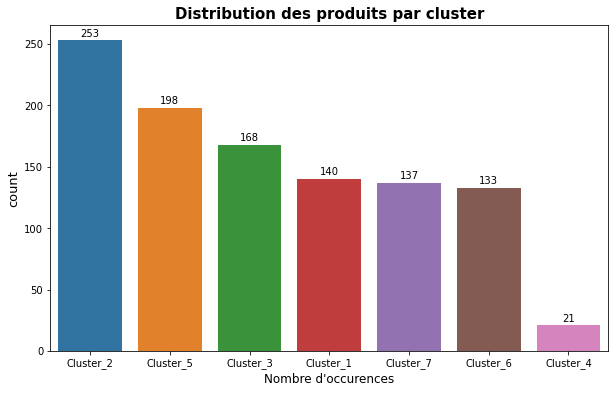

In [82]:
# Distribution des produits par cluster
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Clusters_str', data=df_cvect_desc_lem_cls,
                   order=df_cvect_desc_lem_cls['Clusters_str'].value_counts().index)
plt.title('Distribution des produits par cluster',
          fontweight='bold',
          fontsize=15)
plt.xlabel("Nombre d'occurences", fontsize=12)
etiquette_v(ax, 2)

Nous remarquons qu'avec le countvectorizer sur données lemmatisées, la distribution de nos produits s'éloigne de la distribution originale (150 produits par catégorie).

<div class="alert alert-block alert-warning">
    <p>ARI et représentation graphique</p>
</div>

L'Adjusted Rand Index (ARI) est l'une des métriques les plus utilisées pour valider les performances de clustering.

L'ARI calcule une mesure de similarité entre deux clusters en considérant toutes les paires d'échantillons et en comptant les paires qui sont assignées dans les mêmes ou différents clusters dans les clusters prédits et réels.

L'ARI doit être interprété comme suit :
- ARI >= 0,90 excellente récupération
- 0,80 =< ARI < 0,90 bonne récupération
- 0,65 =< ARI < 0,80 récupération modérée
- ARI < 0,65 mauvaise récupération

In [83]:
# Calcul ARI entre vraies catégories et n° de clusters
def ARI_fct(features) :
    ARI = np.round(adjusted_rand_score(y_cat_num, kmeans_cvect_desc_lem.labels_),4)
    return ARI

In [84]:
ARI_cvect_desc_lem = ARI_fct(kmeans_cvect_desc_lem)

In [85]:
# visualisation du t-SNE selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=categ_list, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

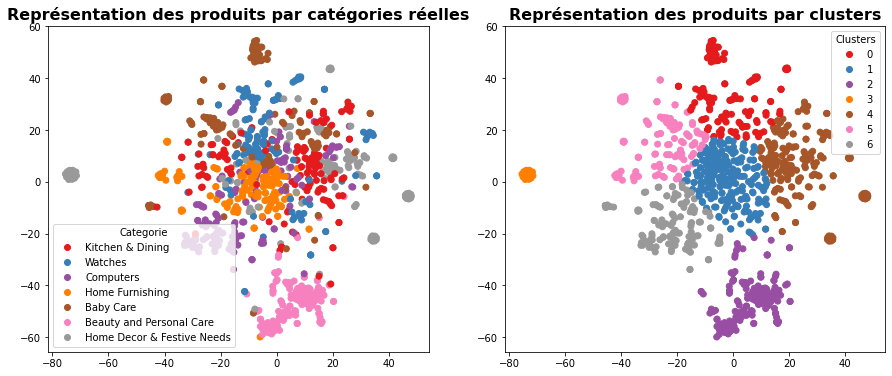

ARI :  0.2811


In [86]:
 TSNE_visu_fct(tsne_30_cvect_desc_lem, y_cat_num, kmeans_cvect_desc_lem.labels_, ARI_cvect_desc_lem)

Nous allons intégrer toutes les étapes précédentes dans une fonction globale qui nous permettra de refaire tourner notre modèle facilement et de récupérer les informations de validation de performance des modèles (durée et ARI):

In [87]:
def ARI_BOW(features) :
    time1 = time.time()
    num_labels=len(categ_list)

    # Standardisation des données
    scaler = StandardScaler()
    features_std = scaler.fit_transform(features)

    # ACP
    pca = PCA(n_components=250)
    X_pca = pca.fit_transform(features_std)

    # t-SNE
    tsne = manifold.TSNE(n_components=2,
                         perplexity=50,
                         n_iter=5000,
                         random_state=42)
    X_tsne = tsne.fit_transform(X_pca)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=7,
                 init='k-means++',
                 random_state=42)
    cls.fit(X_tsne)
    
    # Ajout des clusters dans la dataframe original
    features['Clusters'] = cls.labels_
    
    # Distribution des produits par cluster
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(x='Clusters',
                       data=features,
                       order=features['Clusters'].value_counts().index)
    plt.title('Distribution des produits par cluster',
              fontweight='bold',fontsize=15)
    plt.xlabel("Nombre d'occurences", fontsize=12)
    etiquette_v(ax, 2)
    
    ARI = np.round(adjusted_rand_score(y_cat_num, cls.labels_),4)
    
    time2 = np.round(time.time() - time1,0)
    
    return ARI, X_tsne, cls.labels_, time2

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


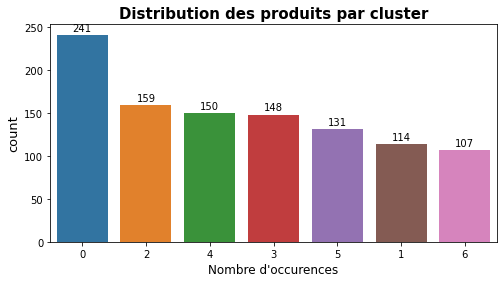

In [88]:
ARI_cvect_desc_lem, X_tsne_cvect_desc_lem, labels_cvect_desc_lem, time2_cvect_desc_lem = ARI_BOW(df_cvect_desc_lem)

In [89]:
df_cvect_desc_lem_recap = {'Modèle':['Countvectorizer'],
                           'Preprocessing':['Lemmatize'],
                           '.fit':['desc_clean_lem'],
                           '.transform':['pname_desc_clean_lem'],
                           'ARI':[ARI_cvect_desc_lem], 
                           "Temps d'entrainement": [time2_cvect_desc_lem],}
df_cvect_desc_lem_recap = pd.DataFrame(data = df_cvect_desc_lem_recap)

In [90]:
df_cvect_desc_lem_recap

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatize,desc_clean_lem,pname_desc_clean_lem,0.253,11.0


##### Countvectorizer sur données lemmatisées avec extraction des features de la colonne product_name (pname_clean_lem)

In [91]:
df_cvect_pname_lem = bag_of_word(data_bow,
                                 'pname_clean_lem',
                                 'pname_clean_lem',
                                 'pname_desc_clean_lem',
                                 CountVectorizer())

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


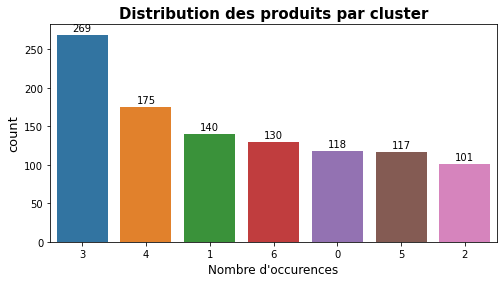

In [92]:
ARI_cvect_pname_lem, X_tsne_cvect_pname_lem, labels_cvect_pname_lem, time2_cvect_pname_lem = ARI_BOW(df_cvect_pname_lem)

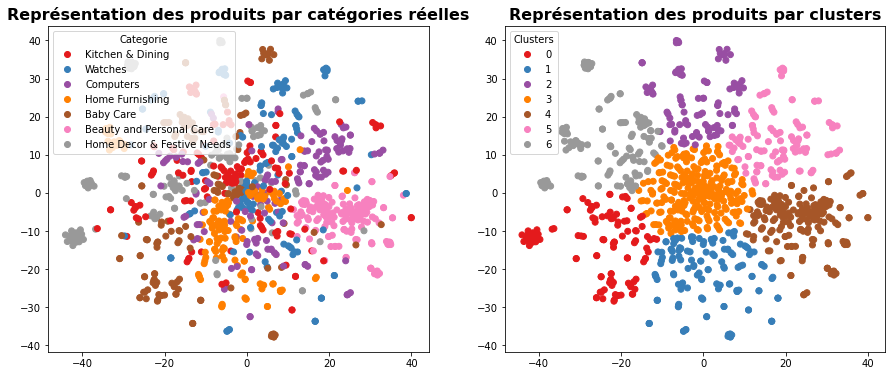

ARI :  0.2081


In [95]:
 TSNE_visu_fct(X_tsne_cvect_pname_lem,
               y_cat_num,
               labels_cvect_pname_lem,
               ARI_cvect_pname_lem)

In [93]:
df_cvect_pname_lem_recap = {'Modèle':['Countvectorizer'],
                            'Preprocessing':['Lemmatize'],
                            '.fit':['pname_clean_lem'],
                            '.transform':['pname_desc_clean_lem'],
                            'ARI':[ARI_cvect_pname_lem], 
                            "Temps d'entrainement": [time2_cvect_pname_lem],}
df_cvect_pname_lem_recap = pd.DataFrame(data = df_cvect_pname_lem_recap)

In [94]:
df_models = pd.concat([df_cvect_desc_lem_recap, df_cvect_pname_lem_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatize,desc_clean_lem,pname_desc_clean_lem,0.2530,11.0
1,Countvectorizer,Lemmatize,pname_clean_lem,pname_desc_clean_lem,0.2081,19.0


##### Countvectorizer sur données non lemmatisées

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- countvectorizer
.fit(descr) puis .transform(pname+descr)
.fit(product_name) .transform(pname+descr) mieux car + imp nom du produit
pca
tsne (2 comp)
puis kmeans (k=7) pas d'optimisation à faire
graph
calcul ARI (0.4, 0.5) faisable meme si pas genial (doit etre > 0.4)

puis refaire avec un autre preprocessing sans lemmatiser

- tfidf
en prenant fit transform qui marche le mieux et le preprocessing qui marche le mieux

Word2Vec 

<div class="alert alert-block alert-info">
    <p>  </p>
</div>

<div class="alert alert-block alert-warning">
    <p> </p>
</div>